# N-Task

This notebook contains the complete N-Task library used for development and basic experimentation

In [24]:
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense
from tensorflow.keras.models import Model
from math import pi

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import random
from random import randrange
import sklearn

from utils import display_progress
import time

## Holographic Reduced Representation (HRR) Functions

In [25]:
def hrr(length, normalized=True):
    """Create a new HRR vector using Tensorflow tensors"""
    length = int(length)      
    shp = int((length-1)/2)
    if normalized:    
        x = tf.random.uniform( shape = (shp,), minval = -pi, maxval = pi, dtype = tf.dtypes.float32, seed = 100, name = None )
        x = tf.cast(x, tf.complex64)
        if length % 2:
            x = tf.math.real( tf.signal.ifft( tf.concat([tf.ones(1, dtype="complex64"), tf.exp(1j*x), tf.exp(-1j*x[::-1])], axis=0)))

        else:  
            x = tf.math.real(tf.signal.ifft(tf.concat([tf.ones(1, dtype="complex64"),tf.exp(1j*x),tf.ones(1, dtype="complex64"),tf.exp(-1j*x[::-1])],axis=0)))
    else:        
        x = tf.random.normal( shape = (length,), mean=0.0, stddev=1.0/tf.sqrt(float(length)),dtype=tf.dtypes.float32,seed=100,name=None)
    return x


def hrrs(length, n=1, normalized=True):
    """Create n new HRR vectors using Tensorflow tensors"""
    return tf.stack([hrr(length, normalized) for x in range(n)], axis=0)


def circ_conv(x, y):
    """Calculate the circular convolution between two HRR vectors"""
    x = tf.cast(x, tf.complex64)
    y = tf.cast(y, tf.complex64)
    return tf.math.real(tf.signal.ifft(tf.signal.fft(x)*tf.signal.fft(y)))


def logmod(x):
    return np.sign(x)*np.log(abs(x) + 1)


def plotFrames(title, *frameGroups, labels):
    fig, ax = plt.subplots()
    for i, group in enumerate(frameGroups):
        keys = tuple(group.keys())
        t = np.arange(keys[0], keys[-1] + 1, 1)
        ax.plot(t, list(group.values()), label=labels[i])
    ax.set(xlabel='Episode', ylabel='Value', title=title)
    ax.grid()
    plt.legend()

## Abstract Task Representation (ATR) Models

Different types of tasks could require different models for handling ATRs. These models greatly increase the power and control over the context layers

In [82]:
class AtrModel:
    def __init__(self, num_tasks=1, task_switch_threshold=0.0, is_dynamic=False, task_add_threshold=0.0, max_num_tasks=1):
        # Parameters
        self.num_tasks = num_tasks
        self.switch_threshold = task_switch_threshold
        self.num_tasks = num_tasks
        self.is_dynamic = is_dynamic
        self.add_threshold = task_add_threshold
        self.max_num_tasks = max_num_tasks
        
        # ATR model information
        self.atr_values = []
        self.context_losses = [0.0 for i in range(num_tasks)]
        self.num_seq_switches = 0
        
        # The defualt hot context
        self.hot_context_idx = 0
        
        # Initialize the ATR values
        self.initialize_atr_values(self.num_tasks)
        
        
    def add_context(self):
        # Increase the number of ATRs
        self.num_tasks += 1
        
        # Add the new ATR value
        self.atr_values.append(self.initial_atr_value())
        self.context_losses.append(0.0)
    
    
    def switch_contexts(self, context_loss, verbose=1):
        """
        Switch to a new task
        """
        if verbose:
            print("Switching... context loss:", context_loss)
            
        # If we have exhausted the context list, pick the one with the lowest loss
        if self.num_seq_switches >= self.num_tasks:
            # Find the context with the lowest loss
            best_fit_idx = self.find_best_fit_context()
            
            if verbose:
                print("Best context loss...", self.context_losses[best_fit_idx])
            
            # Check if a new context should be added
            if self.is_dynamic and self.num_tasks < self.max_num_tasks and self.should_add_context(context_loss, best_fit_idx):
                # Add the new context
                self.add_context()
                
                # Switch to the new context
                self.hot_context_idx = self.num_tasks - 1
                if verbose:
                    print(f"Task switched (added new task): {self.hot_context_idx}")
                
            else:
                # Change to the new context
                self.hot_context_idx = best_fit_idx
                if verbose:
                    print(f"Task switched (found best): {self.hot_context_idx}")

                # Update the ATR value
                self.update_atr_value(self.context_losses[self.hot_context_idx], switched=True)

        else:
            self.next_context()
            if verbose:
                print(f"Task switched to: {self.hot_context_idx}")
    
    
    def update_and_switch(self, context_loss, dynamic_switch=True, verbose=1):
        """Perform an update on the ATR model"""
        
        # Do we need to switch contexts?
        if dynamic_switch and self.should_switch(context_loss):
            
            # Update the tracked context loss
            self.context_losses[self.hot_context_idx] = context_loss
            
            # Count the sequential sequence switches
            self.num_seq_switches += 1
            
            # Switch to the new context
            self.switch_contexts(context_loss, verbose)
            
            # A switch occurred, no ATR updates happened
            return False
        
        # Update the ATR values
        self.update_atr_value(context_loss, switched=False)
        
        # Reset the sequential switch counter
        self.num_seq_switches = 0
        
        # No switch occurred, ATR was updated
        return True


    def get_hot_context():
        """Get the active context index"""
        return self.hot_context_idx
    
    
    def set_hot_context(self, hot_context_idx):
        """Set the active context index"""
        if hot_context_idx not in range(self.num_tasks):
            raise IndexError("The given hot context index does not exist")
        self.hot_context_idx = hot_context_idx
        
    
    def next_context(self):
        """Switch to the next sequential context"""
        self.set_hot_context((self.hot_context_idx + 1) % self.num_tasks)
        return self.hot_context_idx
    
    # Overridable ---------------------------------------------------------------------------------
    
    def context_loss_fn(self, context_delta):
        # Calculate Context Error
        # Keras MSE must have both args be arrs of floats, if one or both are arrs of ints, the output will be rounded to an int
        # This is how responsible the context layer was for the loss
        return tf.keras.losses.mean_squared_error(np.zeros(len(context_delta)), context_delta)
    
    def initial_atr_value(self):
        """Determine the initial value for an ATR"""
        return None
    
    def initialize_atr_values(self, num_tasks):
        """Initialize the `atr_values` parameter"""
        self.atr_values = [self.initial_atr_value() for i in range(num_tasks)]
        
    def update_atr_value(self, context_loss, switched):
        """Update the ATR value"""
        self.atr_values[self.hot_context_idx] = context_loss
    
    def find_best_fit_context(self):
        """Locate the context index with the best fit"""
        return np.argmax(np.subtract(self.atr_values, self.context_losses))
         
    def should_switch(self, context_loss):
        """Determine if the context should switch"""
        # If this context has not been trained on yet, it's OK
        if self.atr_values[self.hot_context_idx] is None:
            return False
        
        # If the context loss exceeds the threshold
        delta = self.atr_values[self.hot_context_idx] - context_loss
        return delta < self.switch_threshold
    
    def should_add_context(self, context_loss, best_fit_context_idx):
        """
        Determine if a new context should be added
        Note: This is only checked after a switch has been determined
        """
        return self.atr_values[self.hot_context_idx] - self.context_losses[best_fit_context_idx] < self.add_threshold

In [83]:
class AtrMovingAverage(AtrModel):
    def update_atr_value(self, context_loss, switched):
        if switched or self.atr_values[self.hot_context_idx] is None:
            self.atr_values[self.hot_context_idx] = context_loss
        else:
            self.atr_values[self.hot_context_idx] = (self.atr_values[self.hot_context_idx] + context_loss) / 2.0

## The Context Layer

The context layer works as an intermediate layer between two other layers. It takes the output tensor from the previous layer and convolves it with an HRR representing the current active context. The resulting tensor from this convolution is fed to the next layer.

Some things to note:
- The kernel is a list of HRRs, one for each task
- The size of the HRR vectors is equal to the number of nodes in the previous layer
- All weights in this layer are constant and never updated

In [98]:
class Context(Layer):
    
    RESULT_UPDATED  = 0 # The ATR model was updated successfully
    RESULT_SWITCHED = 1 # A task switch was triggered in the ATR
    RESULT_ADDED    = 2 # A new task was added to the ATR model
    
    def __init__(self, atr_model):
        super(Context, self).__init__()
        
        self.kernel = None
        self.atr_model = atr_model
        
        # Information Tracking
        self.num_tasks = 0
        self.context_loss = 0.0
        
        
    def _setup_hrr_weights(self):
        # Fetch and store the number of tasks. Used to check for dynamically added tasks
        self.num_tasks = self.atr_model.num_tasks

        # Create the HRR initializer. This will create the list of HRR vectors
        if self.kernel is None:
            initializer = lambda shape, dtype=None: hrrs(self._input_shape, n=self.num_tasks)
        else:
            # If there are previously generated HRRs, they should be retained
            kernel_arr = self.kernel.numpy()
            num_hrrs = max(0, self.num_tasks - len(kernel_arr))
            initializer = lambda shape, dtype=None: np.append(kernel_arr[:self.num_tasks], hrrs(self._input_shape, n=num_hrrs), axis=0)
        
        # Create the weights for the layer.
        # The weights in this layer are generated HRR vectors, and are never updated.
        self.kernel = self.add_weight(name="context", shape=[self.num_tasks, self._input_shape], initializer=initializer, trainable=False)
        
    
    def build(self, input_shape):
        
        # Store the input shape since weights can be rebuilt later
        self._input_shape = int(input_shape[-1])
        
        # Build the n-task information
        self._setup_hrr_weights()
        
        
    def call(self, inputs):
        """
        Calculate the output for this layer.
        
        This layer convolves the input values with the context HRR vector
        to produce the output tensor.
        """
        
        # Fetch the hot context's HRR vector
        context_hrr = self.kernel[self.get_hot_context()]
        
        # Return the resulting convolution between the inputs and the context HRR
        return circ_conv(inputs, context_hrr)
        
    
    def get_hot_context(self):
        """Get the active context index"""
        return self.atr_model.hot_context_idx
    
    
    def set_hot_context(self, index):
        self.atr_model.set_hot_context(index)
        self.context_loss = 0.0
    
    
    def next_context(self):
        """Switch to the next sequential context"""
        return self.atr_model.next_context()
    
    
    def add_context_loss(self, context_loss):
        """Accumulate context loss"""
        self.context_loss += self.atr_model.context_loss_fn(context_loss)
    
    
    def update_and_switch(self, dynamic_switch=True, verbose=1):
        """
        Update ATR values and switch contexts if necessary.
        Returns True if no context switch occurs; False otherwise
        """
        # Update the ATR values. If a task switch occurs, check if a task was added...
        if not self.atr_model.update_and_switch(self.context_loss, dynamic_switch, verbose):
            
            # Check if the number of tasks was dynamically manipulated
            if self.num_tasks != self.atr_model.num_tasks:
                
                # Re-initialize the
                self._setup_hrr_weights()
                
                # Determine if a new task was added or removed
                if self.num_tasks < self.atr_model.num_tasks:
                    return Context.RESULT_ADDED | Context.RESULT_SWITCHED
            
            # A task switch occurred, no ATR updates
            return Context.RESULT_SWITCHED
        
        # No task switched occurred, updated successfully
        return Context.RESULT_UPDATED

## The n-Task Model

The n-Task model is a modified version of the standard Keras model. This new model incorporates the additional functionality and calculations to handle context layers.

Some things to note:
- The model creates a lookup table for context layers

In [85]:
class NTaskModel(Model):
    def __init__(self, *args, loss_fn=None, optimizer=None, **kwargs):
        super(NTaskModel, self).__init__(*args, **kwargs)
        
        #! A temporary way to store things...
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
        # A list of all context layers
        self.context_layers = []
        
        # Debugging
        self.atr_frames = {}
        
        # Misc
        self.total_epochs = 0
        
        # Create the context layer lookup table
        self._create_context_layer_index_list()
        
        
    def compile(self, *args, **kwargs):
        super(NTaskModel, self).compile(*args, **kwargs)
        self.create_context_layer_index_list()
        
    
    def _create_context_layer_index_list(self):
        """
        Create a lookup table for context layers.
        This is required to efficiently update each context layer's loss information
        """
        self.context_layers = [i for i, layer in enumerate(self.layers) if isinstance(layer, Context)]
        self.atr_frames = {i: defaultdict(dict) for i in self.context_layers}
        
        
    def _calc_context_loss(self, context_layer_idx, gradients):
        """
        IMPORTANT: 
        1) Assumes no use of activation function on Ntask layer
        2) Assumes that the layer following the Ntask layer:
            a) Is a Dense layer
            b) Is using bias 
               — ex: Dense(20, ... , use_bias=True) 
               — note Keras Dense layer uses bias by default if no value is given for use_bias param
        3) Assumes index of the next layer's gradient is known within the gradients list returned from gradient tape in a tape.gradient call
        4) If the above points aren't met, things will break and it may be hard to locate the bugs
        """
        # From the delta rule in neural network math
        delta_at_next_layer = gradients[context_layer_idx + 1]
        transpose_of_weights_at_next_layer = tf.transpose(self.layers[context_layer_idx + 1].get_weights()[0])
        
        # Calculate delta at n-task layer
        context_delta = np.dot(delta_at_next_layer, transpose_of_weights_at_next_layer).astype(np.float)
        
        return context_delta
        
    
    def _custom_forward_pass(self, x_train, y_train, batch_size):
        """
        This is the training forward pass for an entire epoch

        !!!!! Read through this code as it is a nonstandard training forward pass ( different than model.fit() )
        & NOTE that this does not apply the gradients ie. this does not do a weight update/learn

        """
        
        grads = None
        
        # Calculate the total number of batches that need to be processed
        num_batches = int(np.ceil(len(x_train) / batch_size))
        
        # Tensorflow 2 style training -- info can be found here: https://www.tensorflow.org/guide/effective_tf2 
        # This is similar to model.fit(), however this is a custom training loop -- ie. it does things differently than model.fit()
        # look at each input and label (there are 4 for the logic gates)
        for start, end in ((s*batch_size, (s + 1)*batch_size) for s in range(num_batches)):
            
            # Slice into batch
            x = x_train[start:end]
            y = y_train[start:end]
            
            with tf.GradientTape() as tape:
                predictions = self(x, training=True) # Forward pass
                loss = self.loss_fn(y, predictions) # Get the loss
            
            # Extract the gradients for the loss of the current sample
            gradients = tape.gradient(loss, self.trainable_variables)
            
            # Add up the total gradients
            if grads is None:
                grads = gradients
            else:
                grads = np.add(grads, gradients)
            
            for context_layer_idx in self.context_layers:
                self.layers[context_layer_idx].add_context_loss(self._calc_context_loss(context_layer_idx, gradients))
                
        return grads
                
        
    def fit(self, x_train, y_train, n_epochs=1, shuffle=True, progress=False, explicit_contexts=None, batch_size=None, verbose=1):
        
        # Explicit context learning: specify the contexts for ecah of the layers. None=dynamic
        if explicit_contexts is not None:
            if len(explicit_contexts) != len(self.context_layers):
                raise ValueError("Length of explicit contexts does not match the number of context layers")
            for i, idx in enumerate(self.context_layers):
                if explicit_contexts[i] is not None:
                    self.layers[idx].set_hot_context(explicit_contexts[i])
        else:
            explicit_contexts = [None for x in self.context_layers]
        
        # Determine the default batch size
        if batch_size is None:
            batch_size = len(x_train)
        
        # Shuffle the dataset
        x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
        
        epoch = 0
        while epoch < n_epochs:
            
            # DEBUG; Display progress
            if progress:
                display_progress(epoch / n_epochs, title=str([self.layers[i].get_hot_context() for i in self.context_layers]))
            
            # Reset the context loss
            for idx in self.context_layers:
                self.layers[idx].context_loss = 0.0
            
            # Perform a forward pass
            grads = self._custom_forward_pass(x_train, y_train, batch_size)
            
            # Iterate backwards over the context layers. If a context switch occurs, don't check any other layers
            switched = False
            for i in range(len(self.context_layers) - 1, -1, -1):
                # Fetch the context layer
                context = self.layers[self.context_layers[i]]
                
                # Check if explicit context learning for this layer is set
                dynamic_switch = explicit_contexts[i] is None
                
                # Update the layer and indicate if a task switch occurred
                if context.update_and_switch(dynamic_switch, verbose=verbose) & Context.RESULT_SWITCHED:
                    # A task switch occurred, don't update any other layers/weights
                    switched = True
                    break
            
            # If no task switch occurred, we can update the weights of the network
            if not switched:
                epoch += 1
                self.total_epochs += 1
                
                # Apply the gradients
                self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

                for idx in self.context_layers[::-1]:
                    for t in range(self.layers[idx].num_tasks):
                        self.atr_frames[idx][t][self.total_epochs] = self.layers[idx].atr_model.atr_values[t]
                        
                # Reshuffle the dataset
                x_train, y_train = sklearn.utils.shuffle(x_train, y_train)
                        
                        
    def get_contexts(self):
        """Get the hot context from all context layers"""
        return [self.layers[i].get_hot_context() for i in self.context_layers]
            
                    
    def plot_atr_values(self):
        for idx in self.context_layers:
            n = self.layers[idx].num_tasks
            plotFrames(f"ATR Values for Context Layer {idx}", *self.atr_frames[idx].values(), labels=[i for i in range(n)])

___

# Logic Gate Task

In [86]:
def train(model, inputs, labels, cycles, epochs, shuffle=True, show_progress=False, batch_size=None, verbose=0):
    last_index = None
    indices = list(range(len(labels)))
    
    for cycle in range(cycles):
        
        # If the previous task is repeated, swap with a random task
        if last_index == indices[0]:
            i = randrange(1, len(indices))
            indices[0], indices[i] = indices[i], indices[0]
        
        # Train on each batch in the dataset
        for i in indices:
            print(i)
            model.fit(inputs, labels[i], epochs, progress=show_progress, batch_size=batch_size, verbose=verbose)
            assert i == model.layers[model.context_layers[0]].get_hot_context()
        
        # Shuffle at the end to preserver dataset order
        if shuffle:
            list_index = indices[-1]

            # Shuffle the dataset
            random.shuffle(indices)

In [87]:
def validate(model, inputs, labels, num_task_contexts):
    num_passed = 0
    for i in range(num_task_contexts):
        model.layers[model.context_layers[0]].set_hot_context(i)
        result = model(inputs)
        predicted = np.round(result).astype(int).flatten()
        try:
            print(f"Task {i}:", end=' ')
            assert (predicted == labels[i]).all(), "Failed on task:"
            print(result, "Passed")
            num_passed += 1
        except AssertionError:
            print(result, "Failed")
    print(f"{num_passed}/{num_task_contexts} ({100*num_passed//num_task_contexts}%) Learned successfully")

### Loss Function

In [88]:
def loss_fn(labels, predictions):
    return tf.keras.losses.binary_crossentropy(y_true=labels, y_pred=predictions)

### Optimizer

In [89]:
optimizer = tf.keras.optimizers.Adam(1e-4)

### Dataset

In [90]:
labels = np.array([
    [0, 1, 1, 0], # XOR
    [1, 0, 0, 1], # XNOR
    [0, 0, 0, 1], # AND
    [0, 1, 1, 1], # OR
    [1, 0, 0, 0], # NOR
    [1, 1, 1, 0], # NAND
    [1, 0, 1, 0], # Custom 1
    [0, 1, 0, 1]  # Custom 2
])

x_train = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])

___

## Static n-task - 2 Gates (XOR, XNOR) [PASSING]

In [91]:
y_train = labels[:2]
num_task_contexts = len(y_train)

In [92]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [93]:
inp = Input((2,))
x = Dense(40, activation="relu")(inp)
x = Context(AtrMovingAverage(num_task_contexts, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [94]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [95]:
train(model, x_train, y_train, 3, 500, batch_size=1, verbose=1)

0
1
Switching... context loss: tf.Tensor(0.08657401753942828, shape=(), dtype=float64)
Task switched to: 1
0
Switching... context loss: tf.Tensor(0.09006083819891453, shape=(), dtype=float64)
Task switched to: 0
1
Switching... context loss: tf.Tensor(0.1446500652492077, shape=(), dtype=float64)
Task switched to: 1
0
Switching... context loss: tf.Tensor(0.17269743042863445, shape=(), dtype=float64)
Task switched to: 0
1
Switching... context loss: tf.Tensor(0.2587626509000825, shape=(), dtype=float64)
Task switched to: 1


### Model Validation

Assert that the model has learned all logic gates

In [96]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[0.16004175]
 [0.7753888 ]
 [0.7307546 ]
 [0.24736288]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[0.7844529 ]
 [0.19377172]
 [0.25968832]
 [0.7964394 ]], shape=(4, 1), dtype=float32) Passed
2/2 (100%) Learned successfully


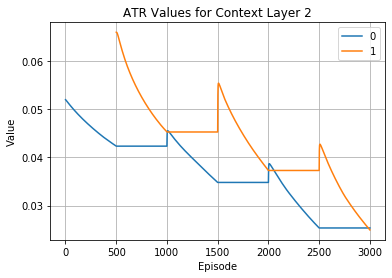

In [97]:
model.plot_atr_values()

___

## Dynamic n-task - 2 Gates (XOR, XNOR) [PASSING]

In [375]:
y_train = labels[:2]
num_task_contexts = len(y_train)

In [376]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [377]:
inp = Input((2,))
x = Dense(40, activation="relu")(inp)
x = Context(AtrMovingAverage(task_switch_threshold=-0.02, is_dynamic=True, task_add_threshold=-0.1, max_num_tasks=num_task_contexts+1))(x)
x = Dense(1, activation="sigmoid")(x)

In [378]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [379]:
train(model, x_train, y_train, 3, 500, batch_size=1)

0
1
0
Task switched to: 0
1
Task switched to: 1
0
Task switched to: 0
1
Task switched to: 1


### Model Validation

Assert that the model has learned all logic gates

In [380]:
validate(model, x_train, y_train, 2)

Task 0: tf.Tensor(
[[0.01707521]
 [0.9751258 ]
 [0.95138764]
 [0.04744345]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[0.97006834]
 [0.02293956]
 [0.0389888 ]
 [0.9693495 ]], shape=(4, 1), dtype=float32) Passed
2/2 (100%) Learned successfully


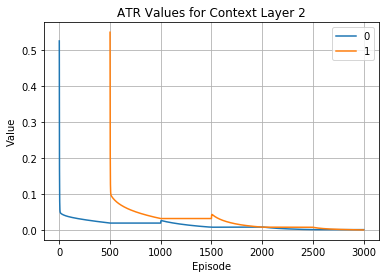

In [381]:
model.plot_atr_values()

## Static n-task - 8 Gates (XOR, XNOR, AND, OR) [PASSING]

In [387]:
y_train = labels
num_task_contexts = len(y_train)

In [388]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [389]:
inp = Input((2,))
x = Dense(128, activation="relu")(inp)
x = Context(AtrMovingAverage(num_task_contexts, task_switch_threshold=-0.02))(x)
x = Dense(1, activation="sigmoid")(x)

In [390]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [391]:
train(model, x_train, y_train, 3, 500, shuffle=True, show_progress=False, batch_size=1)

0
1
Task switched to: 1
2
Task switched to: 2
3
Task switched to: 3
4
Task switched to: 4
5
Task switched to: 5
6
Task switched to: 6
7
Task switched to: 7
6
Task switched to: 0
Task switched to: 1
Task switched to: 2
Task switched to: 3
Task switched to: 4
Task switched to: 5
Task switched to: 6
3
Task switched to: 7
Task switched to: 0
Task switched to: 1
Task switched to: 2
Task switched to: 3
1
Task switched to: 4
Task switched to: 5
Task switched to: 6
Task switched to: 7
Task switched to: 0
Task switched to: 1
Task switched to: 2
0
Task switched to: 2
Task switched to: 3
Task switched to: 4
Task switched to: 5
Task switched to: 6
Task switched to: 7
Task switched to: 0
7
Task switched to: 1
Task switched to: 2
Task switched to: 3
Task switched to: 4
Task switched to: 5
Task switched to: 6
Task switched to: 7
2
Task switched to: 0
Task switched to: 1
Task switched to: 2
5
Task switched to: 3
Task switched to: 4
Task switched to: 5
4
Task switched to: 6
Task switched to: 7
Task swi

### Model Validation

Assert that the model has learned all logic gates

In [394]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[2.7260184e-04]
 [9.9824667e-01]
 [9.9760437e-01]
 [1.6367435e-04]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[9.9807364e-01]
 [3.1682849e-04]
 [5.2276254e-04]
 [9.9946058e-01]], shape=(4, 1), dtype=float32) Passed
Task 2: tf.Tensor(
[[2.8340597e-05]
 [2.2805518e-05]
 [1.8531120e-05]
 [9.9992794e-01]], shape=(4, 1), dtype=float32) Passed
Task 3: tf.Tensor(
[[3.7786220e-05]
 [9.9999088e-01]
 [9.9987835e-01]
 [9.9999952e-01]], shape=(4, 1), dtype=float32) Passed
Task 4: tf.Tensor(
[[9.9988872e-01]
 [5.6573375e-05]
 [6.1916791e-05]
 [1.0072923e-06]], shape=(4, 1), dtype=float32) Passed
Task 5: tf.Tensor(
[[9.9995041e-01]
 [9.9997747e-01]
 [9.9995255e-01]
 [8.4227750e-06]], shape=(4, 1), dtype=float32) Passed
Task 6: tf.Tensor(
[[9.99941528e-01]
 [5.92353754e-05]
 [9.99978244e-01]
 [1.13057606e-04]], shape=(4, 1), dtype=float32) Passed
Task 7: tf.Tensor(
[[4.1033731e-05]
 [9.9984926e-01]
 [4.8479982e-05]
 [9.9989510e-01]], shape=(4, 1), dtype=float32) Pas

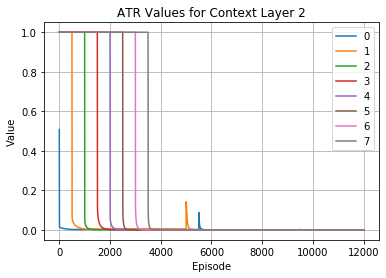

In [395]:
model.plot_atr_values()

## Dynamic n-task - 8 Gates

In [415]:
y_train = labels
num_task_contexts = len(y_train)

In [416]:
random.seed(5)
tf.random.set_seed(5)

### Model

In [417]:
inp = Input((2,))
x = Dense(256, activation="relu")(inp)
x = Context(AtrMovingAverage(is_dynamic=True, task_switch_threshold=-0.02, task_add_threshold=-0.04, max_num_tasks=num_task_contexts+1))(x)
x = Dense(1, activation="sigmoid")(x)

In [418]:
model = NTaskModel(inputs=inp, outputs=x, loss_fn=loss_fn, optimizer=optimizer)

### Training

In [419]:
train(model, x_train, y_train, 3, 750, batch_size=1, verbose=1)

0
1
Switching... tf.Tensor(0.12803729399554487, shape=(), dtype=float64)
Best context loss... tf.Tensor(0.12803729399554487, shape=(), dtype=float64)
Task switched (added new task): 1
2
Switching... tf.Tensor(0.0470387192921962, shape=(), dtype=float64)
Task switched to: 0
Switching... tf.Tensor(0.13979306232325495, shape=(), dtype=float64)
Best context loss... tf.Tensor(0.0470387192921962, shape=(), dtype=float64)
Task switched (added new task): 2
3
Switching... tf.Tensor(0.12245445105664006, shape=(), dtype=float64)
Task switched to: 0
Switching... tf.Tensor(0.06021763706426566, shape=(), dtype=float64)
Task switched to: 1
Switching... tf.Tensor(0.16970973015840154, shape=(), dtype=float64)
Best context loss... tf.Tensor(0.06021763706426566, shape=(), dtype=float64)
Task switched (added new task): 3
4
Switching... tf.Tensor(0.2746182329935062, shape=(), dtype=float64)
Task switched to: 0
Switching... tf.Tensor(0.20009055683310056, shape=(), dtype=float64)
Task switched to: 1
Switchin

### Model Validation

Assert that the model has learned all logic gates

In [421]:
validate(model, x_train, y_train, num_task_contexts)

Task 0: tf.Tensor(
[[2.3417779e-07]
 [9.9999881e-01]
 [9.9999952e-01]
 [3.8337971e-06]], shape=(4, 1), dtype=float32) Passed
Task 1: tf.Tensor(
[[9.9999416e-01]
 [1.1434338e-06]
 [1.1220191e-05]
 [9.9998474e-01]], shape=(4, 1), dtype=float32) Passed
Task 2: tf.Tensor(
[[1.4903513e-07]
 [6.1551469e-07]
 [5.1954984e-08]
 [9.9999988e-01]], shape=(4, 1), dtype=float32) Passed
Task 3: tf.Tensor(
[[7.204879e-07]
 [9.999927e-01]
 [9.999942e-01]
 [1.000000e+00]], shape=(4, 1), dtype=float32) Passed
Task 4: tf.Tensor(
[[9.9999958e-01]
 [4.3514154e-07]
 [1.6052305e-06]
 [1.5638378e-07]], shape=(4, 1), dtype=float32) Passed
Task 5: tf.Tensor(
[[1.0000000e+00]
 [9.9999940e-01]
 [9.9999881e-01]
 [3.9146457e-08]], shape=(4, 1), dtype=float32) Passed
Task 6: tf.Tensor(
[[9.9999988e-01]
 [3.1798587e-07]
 [9.9999952e-01]
 [2.5493891e-06]], shape=(4, 1), dtype=float32) Passed
Task 7: tf.Tensor(
[[4.4993494e-06]
 [9.9999940e-01]
 [5.3090548e-07]
 [9.9999642e-01]], shape=(4, 1), dtype=float32) Passed
8/8 

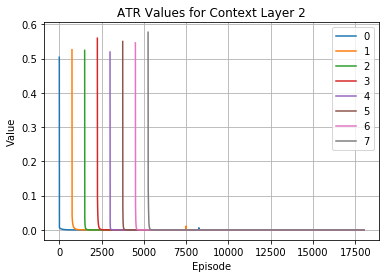

In [422]:
model.plot_atr_values()